> 시계열 분석을 정리하고자 한다. 시계열의 변동성 모델링(ARCH, GARCH 등), VaR 등에 대해 알아보자.

# 변동성

시계열 변동성은 시계열 데이터의 변화량이 시간에 따라 어떻게 변하는지를 측정하는 것이다.

시계열 모델에서는, 변동성 클러스터링(volatility clustering) 과 같은 현상을 설명하기 위해 조건부 변동성 모델(conditional volatility models) 을 사용한다. 예를 들어, GARCH(Generalized Autoregressive Conditional Heteroskedasticity) 모델은 시계열 데이터의 변동성이 시간에 따라 변할 수 있으며, 큰 변동성이 뒤따르는 기간 동안 변동성이 높아질 수 있음을 나타낸다.

## Historical volatility

- 역사적 변동성은 과거 데이터를 바탕으로 계산된 변동성으로, 주로 과거의 가격 변화를 분석하여 계산하며, 시계열 데이터의 표준편차로 측정된다..

$$\sigma = \sqrt{\frac{1}{N-1} \sum_{i=1}^{N} (r_i - \bar{r})^2}$$

In [26]:
import numpy as np

prices = 100 + np.cumsum(np.random.randn(200)) 

returns = np.diff(prices) / prices[:-1]
mean_return = np.mean(returns)
historical_volatility = np.sqrt(np.sum((returns - mean_return)**2) / (len(returns) - 1))
historical_volatility * 100

0.9391742262703004

## Implied Volatility

임플라이드 변동성은 옵션 가격을 바탕으로 시장 참가자들이 예상하는 미래 변동성을 의미한다. 이는 블랙-숄즈 모형과 같은 옵션 가격 모형을 이용하여 역산해 낼 수 있다. 옵션 가격, 행사 가격, 만기까지의 남은 기간, 무위험 이자율, 그리고 배당 수익률을 입력 변수로 사용하여 임플라이드 변동성을 계산할 수 있다.


### 블랙 숄즈 모형

블랙-숄즈 모델은 유럽형 콜 옵션과 풋 옵션의 가격을 평가하기 위한 수학적 모델

$$C(S, t) = S_0 N(d_1) - Xe^{-r(T - t)} N(d_2)$$

$$d_1 = \frac{\ln(\frac{S_0}{X}) + (r + \frac{\sigma^2}{2})(T - t)}{\sigma\sqrt{T - t}}$$

$$d_2 = d_1 - \sigma\sqrt{T - t}$$

여기서

- $C(s,t)$는 t에서 콜 옵션 가격
- $S_0$은 현재 주식 가격, $X$는 옵션 행사 가격, $T$는 만기까지 시간, $r$은 무위험 이자율
- $N(\cdot)$은 표준 정규 분포의 누적 분포 함수
- $\sigma$는 기초자산의 연간 표준 편차, 즉 변동성

임플라이드 변동성은 이러한 모델을 이용해 역으로 계산되는데, 주어진 옵션 가격과 기타 파라미터를 사용하여 $\sigma$를 찾는 과정을 의미한다. 이 과정은 수치적 방법을 사용하여 이루어지며, 정확한 해를 직접 구하는 대신 반복적인 방법을 사용하여 근사값을 찾는다.

In [28]:
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np

# 블랙-숄즈 모델에 의한 콜 옵션 가격 계산 함수
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

# 임플라이드 변동성 계산 함수
def implied_volatility(S, K, T, r, C_market):
    func = lambda sigma: black_scholes_call(S, K, T, r, sigma) - C_market
    IV = brentq(func, 1e-6, 1)
    return IV

# 임의의 파라미터로 예시 계산
S = 100  # 현재 주식 가격
K = 100  # 행사 가격
T = 1    # 만기까지의 시간 (년)
r = 0.05 # 무위험 이자율
C_market = 10  # 시장에서 관측된 콜 옵션 가격

# 임플라이드 변동성 계산
IV = implied_volatility(S, K, T, r, C_market)
print(f"임플라이드 변동성: {IV:.4f}")

임플라이드 변동성: 0.1880


## Conditional volatility

조건부 변동성을 모델링하는 방법으로는 ARCH, GARCH 등이 있으며 아래에서 자세히 다룬다.

# ARCH

ARCH(Autoregressive Conditional Heteroskedasticity) 모델은 시계열 데이터의 **변동성이 시간에 따라 변할 수 있음**을 고려하여 개발되었다. 특히 금융 시장 데이터 같이 큰 변동성 이후에 큰 변동성이 계속 발생하는 변동성 클러스터링(volatility clustering) 현상을 포착하는 데 유용하다. ARCH 모델의 기본 아이디어는 시계열 데이터의 변동성이 **과거의 오차 항에 조건부로 달라진다**는 것이다.

시계열 $y_t$에 대해, 오차 항 $\epsilon_t$:

$$\epsilon_t = \sigma_t z_t$$

여기서 $\{z_t\}$는 평균이 0이고 분산이 1인 i.i.d. 랜덤 변수이며, $\sigma^2_t$는 시간 $t$에서의 조건부 분산을 나타낸다. $\sigma^2_t$는 과거의 정보, 즉 과거의 오차 항의 제곱에 의해 결정된다고 가정한다.

ARCH(q) 모델에서의 조건부 분산은 다음과 같이 주어진다:

$ARCH(q)$:

$$\sigma^2_t=\alpha_0 + \alpha_1 \epsilon^2_{t-1} + \alpha_2 \epsilon^2_{t-2}+ \dots + \alpha_q \epsilon^2_{t-q}$$

여기서 $\alpha_0>0, \alpha_i \geq0(i=1,\dots,q)$이며, $q$는 모델의 차수를 나타낸다.

- 조건부 분산 모델링: ARCH 모델의 핵심 특징 중 하나는 조건부 분산이 과거의 정보, 특히 과거 오차 항의 제곱에 의존한다는 점이다. 이는 시간에 따라 변하는 변동성을 포착할 수 있게 해준다.

- 변동성 클러스터링: ARCH 모델은 변동성 클러스터링 현상, 즉 높은 변동성이 뒤따르는 기간에 변동성이 집중되는 경향을 잘 포착한다. 이는 금융 시장에서 흔히 관찰되는 현상으로, 큰 가격 변동 뒤에는 종종 또 다른 큰 변동이 올 수 있다는 것을 의미한다.

- 시계열의 두께 꼬리 현상: 금융 시계열 데이터는 종종 정규 분포보다 두꺼운 꼬리(fat tails)를 가진다. ARCH 모델은 이러한 두꺼운 꼬리 현상을 잘 설명할 수 있으며, 이는 금융 시장의 극단적인 사건을 모델링하는 데 유용하다.

- 시간 가변 변동성: ARCH 모델은 시간에 따라 변동성이 달라질 수 있다는 가정 하에 구축되었다. 이는 고정된 변동성 가정을 사용하는 전통적인 시계열 모델과 구별되는 특징이다.

약정상성 조건: $\sum^q_{i=1}{\alpha_i}<1$

In [6]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

# 임의의 데이터 생성
np.random.seed(42)
n = 2000
omega = 0.2
alpha = 0.5
errors = np.random.normal(0, 1, n)
series = np.zeros(n)
for t in range(1, n):
    series[t] = np.sqrt(omega + alpha * series[t-1]**2) * errors[t]

Iteration:      5,   Func. Count:     30,   Neg. LLF: 1680.7434992918677
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1680.7434992918677
            Iterations: 5
            Function evaluations: 30
            Gradient evaluations: 5
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1680.74
Distribution:                  Normal   AIC:                           3367.49
Method:            Maximum Likelihood   BIC:                           3384.29
                                        No. Observations:                 2000
Date:                Thu, Apr 11 2024   Df Residuals:                     1999
Time:                        11:18:34   Df Model:                            1
        

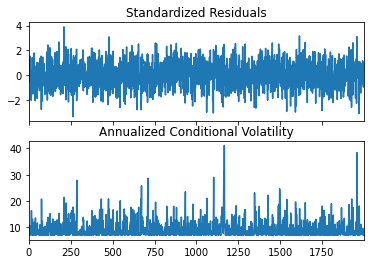

In [7]:
# ARCH(1) 모델 적합
am = arch_model(series, vol='Arch', p=1)
res = am.fit(update_freq=5)

# 결과 출력
print(res.summary())

# 조건부 분산 시각화
fig = res.plot(annualize='D')
plt.show()

# GARCH

GARCH(Generalized Autoregressive Conditional Heteroskedasticity) 모델은 ARCH 모델을 일반화한 것으로, 조건부 분산이 과거의 예측 오차뿐만 아니라 **과거의 조건부 분산 자체**에도 의존한다는 점에서 ARCH 모델을 확장한다.

GARCH(p, q) 모델에서의 조건부 분산은 다음과 같이 주어진다:

$GARCH(q)$:

$$\sigma^2_t=\alpha_0 + \sum_{i=1}^q{\alpha_i \epsilon^2_{t-i}} + \sum_{j=1}^p{\beta_j \sigma^2_{t-j}}$$

여기서 $\alpha_0>0, \alpha_i,\beta_j \geq0(i=1,\dots,q)$이며, $q$는 ARCH항, $p$는 GARCH항 차수를 나타낸다.

약정상성 조건: $\sum^q_{i=1}{\alpha_i} + \sum^p_{j=1}{\beta_j} < 1$
- 조건부 분산이 시간이 지나면서 안정적인 값을 유지하고, 분산이 무한대로 발산하지 않도록 함으로써 장기적인 예측 가능성을 보장함

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1680.74
Distribution:                  Normal   AIC:                           3369.49
Method:            Maximum Likelihood   BIC:                           3391.89
                                        No. Observations:                 2000
Date:                Thu, Apr 11 2024   Df Residuals:                     1999
Time:                        11:19:09   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0221  1.079e-02      2.049  4.051e-02 [9.

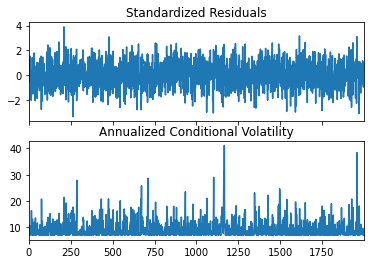

In [9]:
# GARCH(1,1) 모델 적합
garch11 = arch_model(series, p=1, q=1)  # GARCH(1,1) 모델 정의
res = garch11.fit(disp='off')  # 모델 적합, disp='off'는 적합 과정 메시지 끄기

# 적합 결과 요약
print(res.summary())

# 조건부 분산 시각화
fig = res.plot(annualize='D')
plt.show()

C:\Users\master\anaconda3\envs\py38\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Forecasted Volatility:
          h.01      h.02      h.03      h.04      h.05      h.06      h.07  \
1999  0.258216  0.321242  0.351836  0.366686  0.373895  0.377394  0.379093   

          h.08      h.09      h.10  
1999  0.379917  0.380317  0.380512  


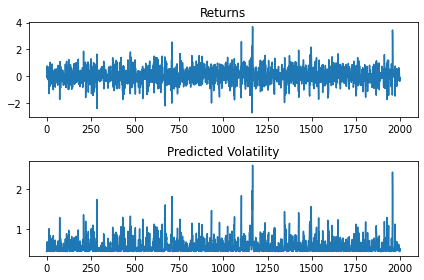

In [14]:
# 변동성 예측
forecasts = res.forecast(horizon=10)  # 다음 10일간의 변동성 예측
print("Forecasted Volatility:")
print(forecasts.variance[-1:])  # 마지막 관측치에 대한 변동성 예측 출력

# 적합된 모델과 예측된 변동성 시각화
fig, ax = plt.subplots(2, 1, figsize=(6, 4))

# 실제 수익률
ax[0].plot(series)
ax[0].set_title('Returns')

# 예측된 조건부 변동성
predicted_volatility = np.sqrt(res.params['omega'] + res.params['alpha[1]'] * series**2 + res.params['beta[1]'] * res.conditional_volatility**2)
ax[1].plot(predicted_volatility)
ax[1].set_title('Predicted Volatility')

plt.tight_layout()
plt.show()

## EGARCH

EGARCH(Exponential Generalized Autoregressive Conditional Heteroskedasticity) 모델은 변동성의 비대칭 효과를 모델링 할 수 있다는 점에서 GARCH 모델을 확장한다. 금융 시장에서는 종종 나쁜 뉴스가 좋은 뉴스보다 더 큰 변동성을 초래하는 현상(레버리지 효과)이 관찰된다.

$$\log(\sigma^2_t) = \alpha_0 + \sum^q_{i=1}{\alpha_i g(Z_{t-i})} + \sum^p_{j=1}{\beta_j \log(\sigma^2_{t-j})}$$

여기서 $g(Z_t)=\theta Z_t + \gamma(|Z_t|-E|Z_t|)$, $Z_t = \frac{\epsilon_t}{\sigma_t}$는 표준화된 잔차, $\theta, \gamma$는 레버리지 효과를 캡쳐하는 파라미터이며, $\gamma>0$이면 나쁜 뉴스가 변동성을 더 크게 증가시킨다는 것을 나타낸다.

## TGARCH

TGARCH(Threshold GARCH) 모델은 또 다른 변동성의 비대칭 효과를 모델링하는 데 사용된다. TGARCH 모델에서는 변동성이 과거의 음의 충격과 양의 충격에 다르게 반응한다고 가정한다. 이 모델은 금융 시계열 데이터에서 관찰되는 레버리지 효과를 포착할 수 있다.

$$\sigma^2_t = \alpha_0 + \sum_{i=1}^q{(\alpha_i\epsilon_{t-i}^2 + \gamma_i \epsilon_{t-i}^2I_{\{\epsilon_{t-i} < 0\}}}) + \sum_{j=1}^p \beta_j \sigma^2_{t-j}$$

여기서 $I_{\{\epsilon_{t-i} < 0\}}$는 $\epsilon_{t-i}$가 음수일 때 1이고, 그렇지 않을 때 0인 지시 함수이다.

## IGARCH

IGARCH(Integrated GARCH) 모델은 GARCH 모델의 특별한 경우로, 조건부 분산의 계속된 증가를 허용하여 장기적인 변동성의 예측을 개선한다. 
IGARCH 모델에서는 $\sum^q_{i=1}{\alpha_i} + \sum^p_{j=1}{\beta_j} = 1$ 조건이 만족된다. 이 조건 하에서는 분산이 시간에 따라 적분(integrated)되어 장기적인 메모리를 가지게 된다.

## 다변량 GARCH

다변량 GARCH(Multivariate GARCH, MGARCH) 모델은 여러 개의 시계열 변수 간의 변동성과 상호작용을 동시에 모델링하는 방법을 제공한다. 이러한 모델은 특히 금융 데이터 분석에서 유용하게 활용되며, 여러 자산의 수익률 시계열이 서로 어떻게 상호작용하는지, 그리고 이들 간의 조건부 변동성과 공변동성을 어떻게 예측할 수 있는지를 이해하는 데 도움을 준다.

**BEKK(Baba, Engle, Kraft, and Kroner)** 모델

$$H_t = C + A\epsilon_{t-1}\epsilon_{t-1}'A' + BH_{t-1}B'$$

여기서,
- $H_t$는 조건부 공분산 행렬(covariance matrix)이며, 시간 $t$에서의 예측된 변동성과 공변동성을 포함한다.
- $C$는 상수 행렬이며, 장기 평균 변동성을 나타낸다.
- $A, B$는 모델 파라미터 행렬로, 각각 과거의 충격($\epsilon_{t-1}\epsilon_{t-1}'$)과 이전의 조건부 공분산 행렬($H_{t-1}$)의 영향을 나타낸다.
- $\epsilon_{t-1}$은 $t-1$ 시점의 오차항 벡터이다.

BEKK 모델은 공분산 행렬의 양의 정부호성을 보장하며, 변동성의 비대칭 효과와 공변동성의 시간에 따른 변화를 모델링할 수 있다는 장점이 있다. 그러나 파라미터의 수가 많아 계산이 복잡하다는 단점도 있다.

**CCC(Constant Conditional Correlation)** 모델

CCC 모델은 여러 시계열 변수들 간의 조건부 상관관계가 시간에 따라 변하지 않고 일정하다고 가정한다. CCC 모델은 다음과 같이 구성된다:

- 각 변수의 조건부 분산은 개별적인 univariate GARCH 모델로 모델링된다.
- 모든 변수 쌍 간의 조건부 상관관계는 상수로 고정된다.

CCC 모델의 강점은 그 구조의 단순함에 있으며, 이로 인해 계산적으로 효율적이다. 그러나 모든 시계열 쌍의 상관관계가 시간에 따라 변하지 않는다는 가정은 현실적인 금융 데이터에는 항상 적합하지 않을 수 있다.

**DCC(Dynamic Conditional Correlation)** 모델

CCC 모델은 시간에 따라 변하는 조건부 상관관계를 모델링할 수 있는 주요 장점이 있다. DCC 모델의 공분산 구조는 다음과 같이 주어진다:

$$H_t = D_tR_tD_t$$

여기서 $D_t$는 시간$t$에서의 조건부 분산의 제곱근을 대각선에 배치한 대각행렬이며, $R_t$는 시간 $t$에서의 상관관계 행렬이다. 

DCC 모델은 특히 금융 시장에서 자산 간의 변동 상관관계가 시간에 따라 변화하는 현상을 잘 포착한다.

**DVECH(Diagonal VECH)** 모델

DVECH 모델은 VECH 모델의 특수한 경우로, 조건부 공분산 행렬의 대각성분만이 자신의 과거 값과 과거 충격의 함수로 모델링된다는 특징을 가진다. DVECH 모델은 다음과 같이 표현할 수 있다:
$$H_t = C + A\odot (\epsilon_{t-1}\epsilon_{t-1}') + B\odot H_{t-1}$$


DVECH 모델은 BEKK 모델에 비해 계산이 더 간단하다는 장점이 있지만, 공분산 행렬의 비대각 요소를 직접 모델링하지 않는다는 제한이 있다.

각각의 다변량 GARCH 모델은 특정한 상황과 데이터의 특성에 따라 선택될 수 있으며, 금융 시장 데이터의 복잡한 동적 변동성을 이해하고 예측하는 데 중요한 도이다.


이외에도 GOGARCH, FIEGARCH, COGARCH 등의 모델이 있다.

- GOGARCH(Generalized Orthogonal GARCH): 다변량 시계열 데이터의 주성분 분석(PCA)와 유사한 개념을 변동성 모델링에 적용
- FIEGARCH (Fractionally Integrated GARCH): 변동성의 자기상관이 감소하는 속도가 지수적이 아니라 다항식적으로 감소한다는 가정 하에, 장기간에 걸쳐 느리게 감소하는 자기상관 구조를 모델링
- COGARCH (Continuous-time GARCH): 연속 시간에서의 GARCH 모델링, 고빈도 금융 데이터나, 시간 간격이 일정하지 않은 데이터를 분석할 때 유용

## CHARMA

Conditional Heteroscedastic ARMA (CHARMA) 모델은 시계열 데이터의 평균과 변동성이 모두 시간에 따라 변화하는 경우에 사용되는 모델이다. 이 모델은 ARMA모델의 개념을 변동성 모델링에 적용한 것으로, 시계열의 조건부 평균뿐만 아니라 조건부 분산도 모델링한다.

CHARMA 모델에서, 시계열의 조건부 평균은 ARMA 모델을 통해 모델링되며, 이는 과거의 관측값과 과거의 오차 항들의 선형 조합으로 표현된다. 한편, 시계열의 조건부 분산은 이와 유사한 방식으로 모델링되지만, 여기에는 과거의 분산 값과 과거의 오차 항들이 사용된다. 따라서 CHARMA 모델은 시계열의 평균과 분산이 모두 과거의 정보에 의존한다고 가정한다.

- 조건부 평균: $y_t = \phi_0 + \sum_{i=1}^p \phi_i y_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \epsilon_t$
- 조건부 분산: $\sigma_t^2 = \alpha_0 + \sum_{i=1}^P \alpha_i \sigma_{t-i}^2 + \sum_{j=1}^Q \beta_j \epsilon_{t-j}^2$

여기서,

- $y_t$는 시점 t에서의 시계열 값, $\epsilon_t$ 는 시점 t에서의 오차 항, $\sigma_t^2$는 시점 $t$에서의 조건부 분산을 나타낸다.
- $\phi_i$와 $\theta_j$는 ARMA 모델의 파라미터, $\alpha_i$와 $\beta_j$는 조건부 분산을 모델링하기 위한 파라미터이다.
- $p$와 $q$는 ARMA 모델의 차수, $P$와 $Q$는 변동성 모델의 차수를 나타낸다.

# Risk

## VaR

Value at Risk (VaR)는 금융 리스크 관리에서 널리 사용되는 중요한 지표 중 하나이다. VaR은 특정 기간 동안 주어진 확률로 예상되는 최대 손실액을 나타낸다. 간단히 말해, VaR은 "주어진 시간 동안, 특정 신뢰 수준에서, 최악의 경우에 얼마나 많은 손실이 발생할 수 있는가"를 수치로 표현한 것이다.

VaR은 금융 포트폴리오의 손실 위험을 측정하는 방법으로, 특정 기간(일반적으로 하루, 한 달 등)과 특정 신뢰 수준(예: 95%, 99%)에 대해 정의된다. 예를 들어, 하루 95% VaR이 1백만 달러라면, 하루 동안 5% 확률로 1백만 달러 이상의 손실이 발생할 수 있음을 의미한다.

**VaR의 계산 방법**

- **역사적 시뮬레이션 방법**: 이 방법은 과거 데이터를 기반으로 VaR을 계산한다. 과거 수익률 분포에서 특정 신뢰 수준에 해당하는 손실을 직접 찾아내어 VaR을 결정한다.

- **분산-공분산(Variance-Covariance) 방법**: 이 방법은 수익률이 정규 분포를 따른다고 가정하고, 포트폴리오의 평균 수익률과 표준편차를 이용해 VaR을 계산한다. 계산이 상대적으로 간단하지만, 수익률이 정규 분포를 따르지 않는 경우 정확성이 떨어질 수 있다. parametric-VaR이라고도 한다.

$$VaR_{\alpha} = -(\mu-Z_\alpha \cdot \sigma) \cdot V$$

여기서,
- $VaR_\alpha$는 주어진 신뢰 수준 $\alpha$에서의 VaR 값
- $\mu$는 포트폴리오 수익률의 평균
- $Z_\alpha$는 주어진 신뢰 수준에서의 정규 분포의 $Z$-값
- $\sigma$는 포트폴리오 수익률 표준편차
- $V$는 포트폴리오 현재 가치

In [11]:
import numpy as np
from scipy.stats import norm

# 예제 데이터: 임의의 일일 수익률 데이터
returns = np.random.normal(0.001, 0.02, 250)

# 포트폴리오 가치 설정
portfolio_value = 1000000  # 100만 달러

# 신뢰 수준 설정 (95%)
confidence_level = 0.95

# VaR 계산
mean_return = np.mean(returns)
std_deviation = np.std(returns)
# VaR 계산
VaR = -norm.ppf(1 - confidence_level, mean_return, std_deviation) * portfolio_value
print(f"1-Day 95% VaR: ${VaR2:,.2f}")

1-Day 95% VaR: $34,673.59


- **몬테카를로 시뮬레이션 방법**: 이 방법은 컴퓨터 시뮬레이션을 이용하여 수많은 시나리오를 생성하고, 이러한 시나리오를 바탕으로 VaR을 계산한다. 몬테카를로 시뮬레이션은 복잡한 금융 상품이나 비정규 분포를 가진 수익률에 대해서도 VaR을 계산할 수 있는 장점이 있다.

In [23]:
# 초기 포트폴리오 가치
portfolio_value = 1000000

# 예상 수익률 및 변동성
mean_return = 0.001
volatility = 0.02

# 시뮬레이션 횟수 및 시간 기간 (일 단위)
num_simulations = 10000
time_horizon = 1  # 1일

# VaR의 신뢰 수준
confidence_level = 0.95

# 일일 수익률 시뮬레이션
simulated_returns = np.random.normal(mean_return, volatility, num_simulations)

# 포트폴리오 가치 변화 계산
simulated_end_values = portfolio_value * (1 + simulated_returns)

# 손실 계산
losses = portfolio_value - simulated_end_values

# VaR 계산
VaR = np.percentile(losses, (1 - confidence_level) * 100)

print(f"1-Day VaR at {confidence_level * 100}% confidence level: ${VaR:,.2f}")

1-Day VaR at 95.0% confidence level: $-34,155.34


## CVaR(조건부 VaR)

Conditional Value at Risk (CVaR), 또는 Expected Shortfall (ES)은 VaR을 넘어서는 손실의 평균값을 측정한다. CVaR은 주어진 신뢰 수준에서 Value at Risk (VaR)을 초과하는 손실에 대한 조건부 기대값을 나타낸다. CVaR은 VaR보다 더 보수적인 리스크 측정치로, 극단적 손실의 가능성을 더 잘 반영한다.

**$CVaR$**:

$$CVar_\alpha = - \frac{1}{1-\alpha}\int^1_\alpha{VaR_\gamma(L)d\gamma}$$

In [24]:
# CVaR 계산
CVaR = -(1 / (1 - confidence_level)) * norm.pdf(norm.ppf(1 - confidence_level)) * std_deviation - mean_return
CVaR = CVaR * portfolio_value
print(f"1-Day 95% CVaR: ${CVaR:,.2f}")

1-Day 95% CVaR: $-46,123.47
